In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append("../")

### Import Desired Tires

In [30]:
all_tires = {
    "Hoosier_18x6.0-10_LCO_6_cornering":{"long":None, "lat":None},
    "Hoosier_18x6.0-10_LCO_7_cornering":{"long":None, "lat":None},
    "Hoosier_18x6.0-10_R20_6_cornering":{"long":None, "lat":None},
    "Hoosier_18x6.0-10_R20_7_cornering":{"long":None, "lat":None},
}

### Filter Data

In [31]:
camber = 0 # default camber
pressure = 12 * 6.89476 # default pressure
velocity = 25 * 1.60934 # default velocity
slip_angle = 0
tire_scaling = 2/3

tire_dict = all_tires.items()

for name, tire in tire_dict:
    try:
        df = pd.read_csv(f"../processing/results/{name}.csv")
        tire["long"] = df[(df["pressure"] == pressure) & (df["velocity"] == velocity) & (df["camber"] == camber) & (df["slip"] == slip_angle)]
    except:
        print("Error getting long data for {0}".format(name))

    try:
        df = pd.read_csv(f"../processing/results/{name}.csv")
        tire["lat"] = df[((df["velocity"] == velocity) & (df["pressure"] == pressure) & (df["camber"] == camber))]
    except:
        print("Error getting lateral data for {0}".format(name))

### Calculate Lateral Friction Coefficient

In [32]:
peak_mu_lst = []
normal_load_lst = []
tire_name = []

normal_loads = sorted(np.array(tire["lat"]["load"].unique()))

for name, tire in all_tires.items():
    current_peak_mu = []
    current_normal_load = []
    for load in normal_loads:
        if load > -300:
            continue
        temp = tire["lat"][tire["lat"]["load"] == load]
        peak_mu = max(temp["FY"]) * 2/3 / abs(load)

        current_peak_mu.append(peak_mu)
        current_normal_load.append(load)

    normal_load_lst.append(current_normal_load)
    peak_mu_lst.append(current_peak_mu)
    tire_name.append(name[:23])

### Check mu visually to filter out points

Text(0, 0.5, 'Lateral Friction Coefficient')

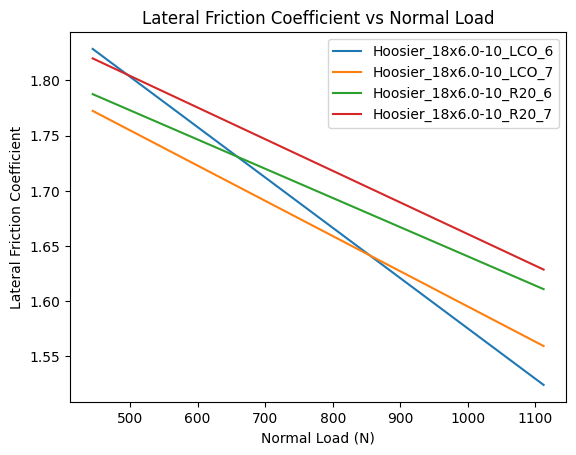

In [37]:
slope_magnitudes = []

for i in range(len(peak_mu_lst)):
    adjusted_FZ = -1 * np.array(normal_load_lst[i])

    m, b = np.polyfit(adjusted_FZ, peak_mu_lst[i], 1)
    slope_magnitudes.append(abs(m))

    x_vals = np.linspace(min(adjusted_FZ), max(adjusted_FZ), 100)

    plt.plot(x_vals, m * x_vals + b)
    # plt.scatter(adjusted_FZ, reversed_mu)

plt.legend(tire_name)
plt.title("Lateral Friction Coefficient vs Normal Load")
plt.xlabel("Normal Load (N)")
plt.ylabel("Lateral Friction Coefficient")

### Save Tire Names and Mu vs FZ Slope Magnitudes to .csv

In [34]:
adjusted_magnitudes = [x * 1000 for x in slope_magnitudes]

output_df = pd.DataFrame()
output_df["Tire"] = tire_name
output_df["abs(slope) * 1000"] = adjusted_magnitudes

output_df.to_csv("18_inch_load_sens.csv")


### Calculate Cornering Stiffnesses

In [35]:
load_lst = []
cornering_stiffness_lst = []
tire_name = []

for name, tire in all_tires.items():
    current_load = []
    current_cornering_stiffness = []
    for load in normal_loads:
        temp = tire["lat"][tire["lat"]["load"] == load][(tire["lat"]["SA"] < 1) & (tire["lat"]["SA"] > -1)]
        cornering_stiffness = (max(temp["FY"]) - min(temp["FY"])) / 2

        current_load.append(load)
        current_cornering_stiffness.append(cornering_stiffness)

    load_lst.append(current_load)
    cornering_stiffness_lst.append(current_cornering_stiffness)
    tire_name.append(name[:23])


/tmp/ipykernel_7730/47000368.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = tire["lat"][tire["lat"]["load"] == load][(tire["lat"]["SA"] < 1) & (tire["lat"]["SA"] > -1)]


### Plot Cornering Stiffness

Text(0, 0.5, 'Cornering Stiffness (N/deg)')

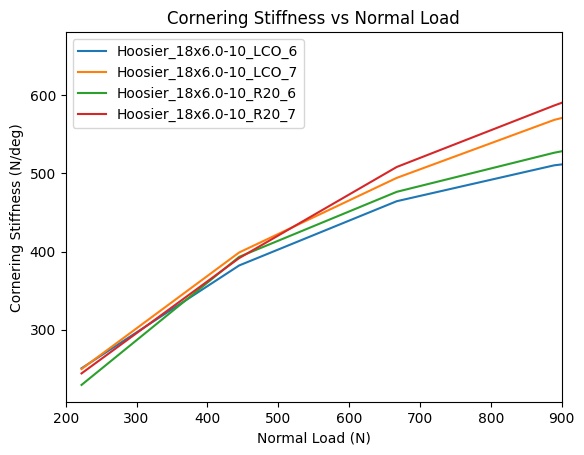

In [36]:
for i in range(len(cornering_stiffness_lst)):
    adjusted_FZ = -1 * np.array(load_lst[i])
    # plt.scatter(adjusted_FZ, cornering_stiffness_lst[i])

    plt.plot(adjusted_FZ, cornering_stiffness_lst[i])

plt.xlim(200, 900)
    
plt.legend(tire_name)
plt.title("Cornering Stiffness vs Normal Load")
plt.xlabel("Normal Load (N)")
plt.ylabel("Cornering Stiffness (N/deg)")